In [111]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [112]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layer):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size,bias=False)
        for k in range(num_hidden_layer-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size,bias=False))
        self.output_layer = nn.Linear(hidden_size, output_size,bias=False)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [113]:
input_size = 784
output_size=10
num_hid_layers=1
num_epochs = 1000
batch_size = 64
learning_rate = 0.01
momentum=0.9

In [114]:
# Import the MNIST dataset as two separate datasets

train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

validation_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Create the data loader for training
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create the data loader for validating

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=1, shuffle=False) 

In [115]:
def network_layer_weight_extraction(model):
    network_weights=[]
    for para in model.named_parameters():
        if 'weight' in para[0]:
            network_weights.append(para[1].detach().numpy())
    return network_weights

In [116]:
def generalization_bound(no_hidden_units):

    model=NeuralNet(input_size,no_hidden_units,output_size,num_hid_layers)
    ReLU_glorot_init(model)

    network_weights=network_layer_weight_extraction(model)
    U_0=network_weights[0].copy()
    V_0=network_weights[1].copy()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) 

    def train_epoch():
        for i, (images, labels) in enumerate(train_dataset_loader):  
            # Move tensors to the configured device
            images = images.reshape(-1, 28*28)
            labels = labels
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backprpagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

        return loss.item()

    for epoch in range(num_epochs):
        loss=train_epoch()
        print ('Epoch {} (hidden units: {}), Loss: {:.3f}'.format(epoch+1,no_hidden_units,loss))
        if loss<0.01:
            break

    network_weights=network_layer_weight_extraction(model)
    U=network_weights[0]
    V=network_weights[1]

    measure=(norm(U_0,ord=2)+norm(U-U_0))*norm(V)+np.sqrt(no_hidden_units)
    print('Measure: {},\nFirst Layer, Spectral Norm: {} Frobenius Norm: {} Distance: {}\nSecond Layer, Spectral Norm: {} Frobenius Norm: {} Distance: {}'.format(measure, norm(U,ord=2), norm(U), norm(U_0-U), norm(V,ord=2), norm(V), norm(V_0-V)))
    return measure

In [117]:
gen_bounds=[generalization_bound(2**(6+n)) for n in range(10)]

Epoch 1 (hidden units: 64), Loss: 0.154
Epoch 2 (hidden units: 64), Loss: 0.562
Epoch 3 (hidden units: 64), Loss: 0.195
Epoch 4 (hidden units: 64), Loss: 0.063
Epoch 5 (hidden units: 64), Loss: 0.173
Epoch 6 (hidden units: 64), Loss: 0.017
Epoch 7 (hidden units: 64), Loss: 0.059
Epoch 8 (hidden units: 64), Loss: 0.244
Epoch 9 (hidden units: 64), Loss: 0.030
Epoch 10 (hidden units: 64), Loss: 0.057
Epoch 11 (hidden units: 64), Loss: 0.013
Epoch 12 (hidden units: 64), Loss: 0.074
Epoch 13 (hidden units: 64), Loss: 0.038
Epoch 14 (hidden units: 64), Loss: 0.011
Epoch 15 (hidden units: 64), Loss: 0.015
Epoch 16 (hidden units: 64), Loss: 0.020
Epoch 17 (hidden units: 64), Loss: 0.016
Epoch 18 (hidden units: 64), Loss: 0.012
Epoch 19 (hidden units: 64), Loss: 0.004
Measure: 218.0572967529297,
First Layer, Spectral Norm: 4.487066745758057 Frobenius Norm: 17.76277732849121 Distance: 14.3228178024292
Second Layer, Spectral Norm: 5.678643703460693 Frobenius Norm: 13.073927879333496 Distance: 10.

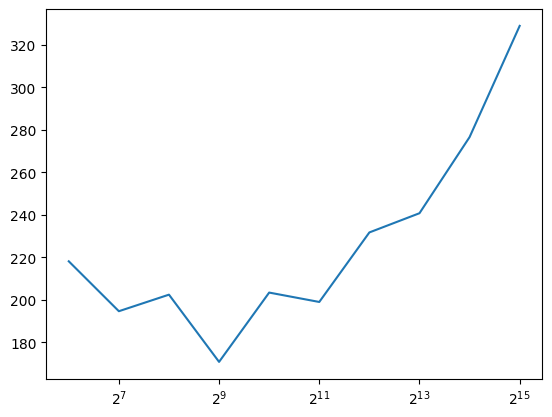

In [119]:
plt.plot([2**(6+n) for n in range(10)], gen_bounds)
plt.xscale('log',base=2)